In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.pipeline import Pipeline, FeatureUnion 
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV, cross_val_score, train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, average_precision_score,\
                            classification_report, precision_recall_curve,\
                            f1_score, auc, confusion_matrix

In [2]:
class knn_w(object):
    
    
    """
    A class to process data from Kaggle and to predict, whether Clients will Churn or not,
    depending on diffierent idicators, used as features and then as predictors. It is an 
    unbalanced data set for binary classification. kNN will be used as the deafault algorithm.
    
    ...

    Attributes
    ----------
    data: pd.DataFrame
          Data to be used for the model
          
    features, target, X_train, X_test, y_train, y_test, y_pred: pd.DataFrame
          Features and targets from data; splitted at random data for train and test; 
          target and predicted variables
    
    best_model, model, summary, cm: obj
          The best model from cross-validation; the model for classification with the
          best parameters from the cross-validation phase; summary from the classification;
          the confusion matrix
    
    cv_scores, accuracy, ap_score, precision, recall, thresholds, auc, f1: np.array
          Classification metrics.
    
    Methods
    -------
    load_data():
        Loads the data, filters it and prints its info.
        
    cross_val():
        Performs 10-fold cross-validation on stadardized data without random splitting. 
        Evaluation of the best hyperparameters is performed. After, another 10-fold
        cross-validation takes place only with the best hyperparameters to avoid biased results.
        In all instances, weight coefficients were assigned to compensate the class imbalance.
        
    split_train_predict():
        Performs initialization of kNN again with weight coefficients, using
        the best hyperparameters from cross_val().
        
    eval_model():
        Evaluates the model performance with y_train. Confusion matrix, Precision-Recall,
        ROC curves and the summary matrix are computed as evaluation metrics. 
        
    """
    
    
    __slots__ = ['data', 'features', 'target', 'X_train','X_test','y_train','y_test', 'y_pred',
                 'model', 'best_model', 'cv_scores','accuracy','ap_score','summary',
                 'precision','recall','thresholds','auc','f1','cm']
    
    
    def __init__(self):
        pass

    
    def load_data(self):
        
        self.data = pd.read_csv('data_churn.csv')
        
        self.data['country'] = self.data['country'].replace(['France', 'Spain', 'Germany'],
                                                            [1, 2, 0])
        
        self.data['gender'] = self.data['gender'].replace(['Female', 'Male'],
                                                            [0, 1])
        
        self.data = self.data.fillna(0)
        self.data['churn'] = self.data['churn'].astype('category')
        
        print('\nData successfully loaded and filtered\n')
        print('\nNumber of negative class members:\n', len(self.data[self.data['churn'] != 1]))
        print('\nNumber of positive class members:\n', len(self.data[self.data['churn'] == 1]))
       
    
    def cross_val(self):
        
        self.features = self.data.iloc[:,1:-1]
        self.target = self.data.iloc[:,-1]
        
        pipe = Pipeline([("preprocess", FeatureUnion([("std", StandardScaler())])),
                         ("classifier", KNeighborsClassifier())])
              
        params = [{"classifier": [KNeighborsClassifier()],
                   "classifier__n_neighbors": [9, 39, 69, 99],
                   "classifier__weights": ['distance'],
                   "classifier__p": [1, 2, 3],
                   "classifier__n_jobs": [-1]}]  

        clf = GridSearchCV(pipe, params, cv = 10, verbose = 0, n_jobs = -1)
        self.best_model = clf.fit(self.features, self.target)
        self.cv_scores = cross_val_score(clf, self.features, self.target, cv = 10, n_jobs = -1)  
        
        
    def split_train_predict(self):
        

        self.model = KNeighborsClassifier(n_neighbors = self.best_model.best_params_['classifier__n_neighbors'], 
                                          weights = 'distance', algorithm = 'auto',
                                          p = self.best_model.best_params_['classifier__p'], 
                                          metric = 'minkowski', n_jobs = -1)
            
    
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(self.features, 
                                                                                self.target, 
                                                                                train_size = 0.9,
                                                                                test_size =  0.1,
                                                                                random_state = 12)
        sc = StandardScaler()
        self.X_train = sc.fit_transform(self.X_train)
        self.X_test = sc.fit_transform(self.X_test)
        
        print('\nTrain data size:\n', self.X_train.shape)
        print('\nTеst data size:\n', self.X_test.shape)
        print('\nTrain label size:\n', self.y_train.shape)
        print('\nTest label size:\n', self.y_test.shape)
            
            
        self.model.fit(self.X_train, self.y_train)

        self.y_pred = self.model.predict_proba(self.X_test)
        
        self.accuracy = accuracy_score(self.y_test, np.round(self.y_pred[:,1]))
        self.ap_score = average_precision_score(self.y_test, np.round(self.y_pred[:,1]),
                                                average = 'micro', pos_label = 1)
        
        print("\nAccuracy: %.2f%%" % (self.accuracy * 100.0))
        print("\nAverage Precision: %.2f%%" % (self.ap_score * 100.0))    
        
    
    def eval_model(self):
        
        self.summary = classification_report(self.y_test, np.round(self.y_pred[:,1]))
        print('\nPrecision, recall, accuracy and f1-score:\n', self.summary)
        
        self.precision, self.recall, self.thresholds = precision_recall_curve(self.y_test, 
                                                                              np.round(self.y_pred[:,1]))
        
        plt.figure()
        plt.plot(self.recall, self.precision)
        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.title('Precision - Recall Curve')
        plt.show()
        
        self.f1, self.auc = f1_score(self.y_test, np.round(self.y_pred[:,1])), auc(self.recall, self.precision)
        print('\nAUC:', f'{self.auc:.2}')
        
        self.cm = confusion_matrix(self.y_test, np.round(self.y_pred[:,1]))
        print('\nThe confusion matrix:\n', self.cm)  

In [3]:
knn_obj = knn_w()

In [4]:
knn_obj.load_data()


Data successfully loaded and filtered


Number of negative class members:
 7963

Number of positive class members:
 2037


In [5]:
knn_obj.cross_val()

In [6]:
knn_obj.best_model.best_params_

{'classifier': KNeighborsClassifier(n_jobs=-1, n_neighbors=9, p=1, weights='distance'),
 'classifier__n_jobs': -1,
 'classifier__n_neighbors': 9,
 'classifier__p': 1,
 'classifier__weights': 'distance'}

In [7]:
knn_obj.best_model.best_score_

0.8392999999999999

In [8]:
np.mean(knn_obj.cv_scores)

0.8376999999999999

In [9]:
knn_obj.split_train_predict()


Train data size:
 (9000, 10)

Tеst data size:
 (1000, 10)

Train label size:
 (9000,)

Test label size:
 (1000,)

Accuracy: 84.90%

Average Precision: 44.10%



Precision, recall, accuracy and f1-score:
               precision    recall  f1-score   support

           0       0.85      0.97      0.91       787
           1       0.80      0.39      0.52       213

    accuracy                           0.85      1000
   macro avg       0.83      0.68      0.72      1000
weighted avg       0.84      0.85      0.83      1000



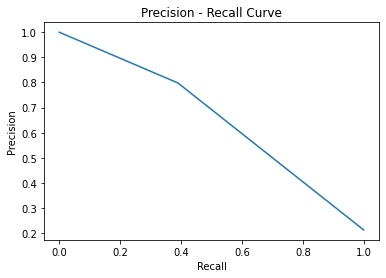


AUC: 0.66

The confusion matrix:
 [[766  21]
 [130  83]]


In [10]:
knn_obj.eval_model()